# 1. Imports

In [15]:
import json
import math
import scipy
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics 
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from numpy.random import randn
from random import *
from statistics import mode
from scipy import stats
%matplotlib inline

# 2. Preparations
## 2.1 Load Data

In [16]:
classrooms = json.load(open('data/raw_data/classrooms.json', 'r'))
pupils = json.load(open('data/raw_data/pupils.json', 'r'))

df = pd.read_pickle('data/processed/df.pkl')
surveysliders = pd.read_pickle('data/processed/surveySlider.pkl')
inputfields = pd.read_pickle('data/processed/inputFields.pkl')
multipleChoice = pd.read_pickle('data/processed/multipleChoice.pkl')
freetext = pd.read_pickle('data/processed/freetext.pkl')
task_df = pd.read_pickle('data/processed/task_df.pkl')
pupil_performance_df = pd.read_pickle('data/processed/pupil_performance.pkl')
# Laden der Datei, in der händisch alle Freitext-Antworten bewertet wurden
pupil_performance_df_rated = pd.read_csv('data/processed/pupil_performance_3.csv', delimiter=';')
pupil_performance_df_rated = pupil_performance_df_rated.set_index('pupilId')

df['duration'] = pd.to_numeric(df['duration'])
surveysliders['duration'] = pd.to_numeric(surveysliders['duration'])
inputfields['duration'] = pd.to_numeric(inputfields['duration'])
multipleChoice['duration'] = pd.to_numeric(multipleChoice['duration'])
freetext['duration'] = pd.to_numeric(freetext['duration'])

In [17]:
#map the classIds to class numbers
classIdListe = ['qFEyvypMn4sAwLwtc', 'GkQSJvPTRWsLnpyR9', 'hZ9Hi9DLZSm5JMbNm', 'NCm8NNbAmNsur5S33', '2xefmoTfmYkhhAZYp', 'Rv7Wf522ZgQhs5LdX', 'Fj6vLBZ78KswTxcPt', 'SwfuMxSGoy4aKziD8', '93uw8K4BBFGYSbYRK', '3dLAJPXXug3EMqbc5', 'brSDebuCak3FfQsg6']
#classNumberList = ["Klasse "+ str(num+1) for num in range(len(classIdListe))]
classNumberList = [str(num+1) for num in range(len(classIdListe))]
classNameDict = {key:value for key, value in zip(classIdListe, classNumberList)}

classIds = []

for index, row in pupil_performance_df_rated.iterrows():
    classIds.append(classNameDict[row["classId"]])

pupil_performance_df_rated["classId"] = classIds

In [18]:
pupil_performance_df_rated.head()

,nr_tasks_per_pupil,total_duration in minutes,average duration per task in minutes,AI-1-v2-1-1,AI-4-v2-1-4,EvalML-1-1,ML-2-1-1,EvalML-1-5,AI-4-v2-1-5,EvalML-1-2,...,AIClosing-1-8_eval,AIClosing-1-8_null_answer,AIClosing-1-8_unknown,AIClosing-1-8_correct_points,AIClosing-1-8_incorrect_points,AIClosing-1-8_irrelevant_points,AIClosing-1-8_rating_content,AIClosing-1-8_rating_format,AIClosing-1-8_rating_creativity,classId
pupilId,,,,,,,,,,,,,,,,,,,,,
Ay6mfswm3SFcQdNJg,66,120.116667,1.819949,62.0,91.0,81.0,71.0,75.0,90.0,90.0,...,pending,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
Z9DkQMmtiPiHtteME,4,25.950000,6.487500,43.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
sqBXKssFvS8pFYAMv,66,66.650000,1.009848,89.0,99.0,96.0,79.0,93.0,100.0,98.0,...,correct,NaN,NaN,NaN,NaN,NaN,5.0,5.0,5.0,1
Kd6FuRsrq6QvPrkKp,6,37.383333,6.230556,78.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
jRT6yzZ2ip5ab5ZFM,66,66.566667,1.008586,90.0,88.0,76.0,71.0,69.0,72.0,100.0,...,correct,NaN,NaN,NaN,NaN,NaN,5.0,5.0,5.0,1


## 2.2 Prepare Helper functions

In [19]:
def surveySliderStatistics(column):
    '''Takes the name of a column, and prints a few basic statistics'''
    print(column.name)
    q3, q1 = np.percentile(column.dropna().values, [75 ,25])
    print("Q1: " + str(q1) + " and Q3: " + str(q3))
    print("median: " + str(column.dropna().median()))
    print("mean: " + str(column.dropna().mean()))
    print("std: " +str(round(column.dropna().std(), 2)))
    print("min: " + str(np.min(column.dropna())) + " und max: " + str(np.max(column.dropna())))
    print("")
    
def calculateDifferences(df):
    """Takes a dataframe and returns the differences between the first two columns as a list"""
    differences= []
    for pupilId in df.dropna().index:
        differences.append(df.loc[pupilId, df.columns[0]]-df.loc[pupilId, df.columns[1]])
    return differences

def print_boolean_percentages(series):
    """Takes a series and prints the percentage of correct, incorrect and irrelevant answers"""
    nr_cases = series.value_counts()[True]+series.value_counts()[False]
    percentage_per_case = 100/nr_cases
    true_percentage = series.value_counts()[True]*percentage_per_case
    false_percentage = series.value_counts()[False]*percentage_per_case
    print(series.name + " has: " + str(true_percentage) + "% True null answers: " + str(false_percentage)+ "% right answers")
    
def spearmanr_pval(x,y):
    """returns the p-value of the correlations calculated with spearman rho"""
    return stats.spearmanr(x,y)[1]

def plot_results_per_sus(dfSlice):
    """Plots the results of each student at timepoints T0 and T1"""
    xticklabels = list(dfSlice.dropna().index)
    fig, ax = plt.subplots(figsize = (len(xticklabels)/2,8))
    dfSlice.dropna().plot.line(ax=ax)
    ax.set_xticks(np.arange(len(xticklabels)))
    ax.set_xticklabels(xticklabels)
    plt.xticks(rotation=90)
    plt.show()
    
def plot_improvement_per_sus (dfSlice):
    """Plots the improvements per student between T0 and T1"""
    fig, ax = plt.subplots()

    for pupilId in dfSlice.dropna().index:
        try:
            t0y = pupil_performance_df_rated.loc[pupilId, dfSlice.dropna().columns[0]]
            t1y = pupil_performance_df_rated.loc[pupilId, dfSlice.dropna().columns[1]]
            ax.plot([0, 1], [t0y, t1y], color='gray')
        except:
            pass

    ax.plot([0,1], [np.mean(dfSlice.dropna()[dfSlice.dropna().columns[0]]), np.mean(dfSlice.dropna()[dfSlice.dropna().columns[1]])], color="red")
    plt.show()
    
def plot_improvements(dfSlice):
    """Pools two functions to plot the results and improvements per student at two timepoints"""
    plot_improvement_per_sus (dfSlice)
    plot_results_per_sus(dfSlice)
    
def cohen_d(x,y):
    """Returns cohens d for two populations"""
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)
    

# 3. Itemschwierigkeit Antwortoptionen

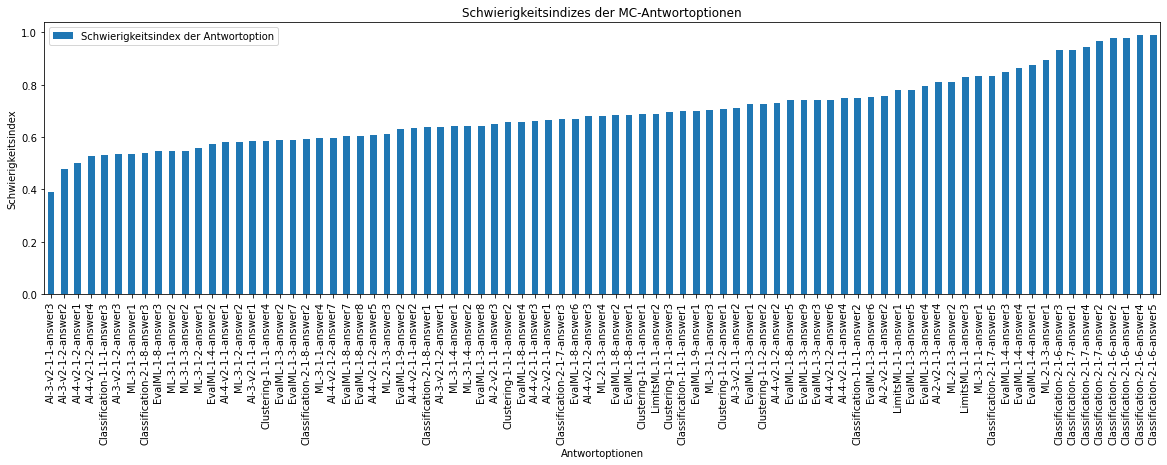

,Schwierigkeitsindex der Antwortoption
Antwortoptionen,
AI-3-v2-1-1-answer3,0.392
AI-3-v2-1-2-answer2,0.480
AI-4-v2-1-2-answer1,0.500
AI-4-v2-1-2-answer4,0.527
Classification-1-1-1-answer3,0.531
...,...
Classification-2-1-7-answer2,0.967
Classification-2-1-6-answer2,0.978
Classification-2-1-6-answer1,0.978


In [20]:
MA_mcs_taskIds = ["AI-2-v2-1-1", "AI-3-v2-1-1", "AI-3-v2-1-2", "AI-4-v2-1-1", "AI-4-v2-1-2", "ML-2-1-3", "ML-3-1-1", "ML-3-1-2", "ML-3-1-3", "ML-3-1-4", "Clustering-1-1-1", "Clustering-1-1-2", "Classification-1-1-1", "Classification-2-1-6", "Classification-2-1-7", "Classification-2-1-8", "LimitsML-1-1", "EvalML-1-3", "EvalML-1-4", "EvalML-1-8", "EvalML-1-9"]

answersByDifficulty = {"Antwortoptionen": [], "Schwierigkeitsindex der Antwortoption": []}

for taskId in MA_mcs_taskIds:
    task_i = multipleChoice[multipleChoice["taskId"] == taskId]
    sampleSolution_i = list(task_i["sampleSolution"][0:1])[0]
    
    with_false_attempts = task_i[task_i["falseAttempts"] == task_i["falseAttempts"]]
    first_falseAttempts_i = [elem[0] for elem in with_false_attempts["falseAttempts"]]
    nr_errors_in_first_false_attempt = np.array([0 for answer in sampleSolution_i])
    for falseAttempt in first_falseAttempts_i:
        nr_errors_in_first_false_attempt += np.array([a != f for a,f in zip(sampleSolution_i,falseAttempt)]).astype(int)
    
    for index, entry in pd.DataFrame(nr_errors_in_first_false_attempt).iterrows():
        answersByDifficulty["Antwortoptionen"].append(taskId+"-answer"+str(index+1))
        answersByDifficulty["Schwierigkeitsindex der Antwortoption"].append(round((len(task_i)-entry[0])/len(task_i),3))

answersByDifficultyDf = pd.DataFrame(answersByDifficulty).set_index('Antwortoptionen')
answersByDifficultyDf.sort_values(by=['Schwierigkeitsindex der Antwortoption'], inplace=True, ascending=True)

answersByDifficultyDf.plot(kind="bar", figsize=(20,5))
plt.title("Schwierigkeitsindizes der MC-Antwortoptionen")
plt.ylabel('Schwierigkeitsindex')
plt.savefig('plots/ItemschwierigkeitsindexTight.png', bbox_inches='tight')
plt.show()

#print(answersByDifficultyDf.to_string())
answersByDifficultyDf

##### Wie viele Antwortoptionen sind wie schwer?

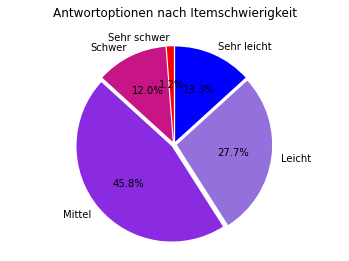

[1, 10, 38, 23, 11]


In [21]:
# Data to plot
cuts = [0, 0.45, 0.55, 0.7, 0.85, 1.0]
numbers_in_each_bracket = []
for i in range(len(cuts)):
    if (i <= 4):
        numbers_in_each_bracket.append(len(answersByDifficultyDf[(answersByDifficultyDf["Schwierigkeitsindex der Antwortoption"]>cuts[i]) & (answersByDifficultyDf["Schwierigkeitsindex der Antwortoption"]<cuts[i+1])]))
labels = ['Sehr schwer', 'Schwer', 'Mittel', 'Leicht', "Sehr leicht"]
#labels = ['0.0-0.45', '0.45-0.55', '0.55-0.7', '0.7-0.85', "0.85-1.0"]

sizes = numbers_in_each_bracket
explode = (0.03, 0.03, 0.03, 0.03, 0.03)

# Plot
fig, ax1 = plt.subplots(nrows=1, ncols=1) #figsize=(9, 4)
colors=["red", "mediumvioletred", "blueviolet", "mediumpurple", "blue"] #https://matplotlib.org/stable/gallery/color/named_colors.html
#colors=["crimson", "purple", "blueviolet", "slateblue", "blue"] 
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode, colors=colors) #,
ax1.set_title('Antwortoptionen nach Itemschwierigkeit', pad=20)
plt.savefig('plots/schwierigkeit_pie.png', bbox_inches='tight')

plt.axis('equal')
plt.show()

#print(numbers_in_each_bracket)

# 4. Evaluation Lernfortschritt

## 4.1 KI
### KI - Selbsteinschätzung
Selbsteinschätzung der SuS zu zwei verschiedenen Zeitpunkten:
* T0: AI-1-v2-1-1
* T1-1 'AI-4-v2-1-4', 'Wie gut hast du jetzt verstanden, was KI ist?'

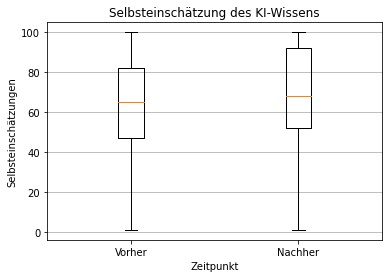


-----Test auf Normalverteilung-----
ShapiroResult(statistic=0.9526786208152771, pvalue=0.0006073114927858114)

-----Wilcoxon-----
WilcoxonResult(statistic=1755.0, pvalue=0.005437282165958155)

-----Effektstärken-----
-0.23904624233021857


In [51]:
# Ergebnisse Plotten
fig, ax1 = plt.subplots(nrows=1, ncols=1) #figsize=(9, 4)
labels = ["Vorher", "Nachher"]
bplot1 = ax1.boxplot([pupil_performance_df["AI-1-v2-1-1"].dropna(), pupil_performance_df["AI-4-v2-1-4"].dropna()],
                     vert=True,
                     #patch_artist=True,
                     labels=labels)
ax1.yaxis.grid(True)
ax1.set_title('Selbsteinschätzung des KI-Wissens')
ax1.set_xlabel("Zeitpunkt")
ax1.set_ylabel("Selbsteinschätzungen")
plt.savefig('plots/KI_selbsteinschätzung.png', bbox_inches='tight')
plt.show()


# Paarweise differenzen berechnen
differences_0_05 = calculateDifferences(pupil_performance_df[["AI-4-v2-1-4", "AI-1-v2-1-1"]])

# Test auf Normalverteilung
print("\n-----Test auf Normalverteilung-----")
print(stats.shapiro(differences_0_05))

# p-Wert = 0.0006 --> wilcoxon signed rank test
print("\n-----Wilcoxon-----")
print(stats.wilcoxon(differences_0_05))

print("\n-----Effektstärken-----")
print(cohen_d(pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4'])["AI-1-v2-1-1"], pupil_performance_df.dropna(subset=["AI-1-v2-1-1", 'AI-4-v2-1-4'])["AI-4-v2-1-4"]))


#### KI - Selbsteinschätzungen - Korrelation mit meiner Bewertung der Textantworten

------------------ Vorher ---------------


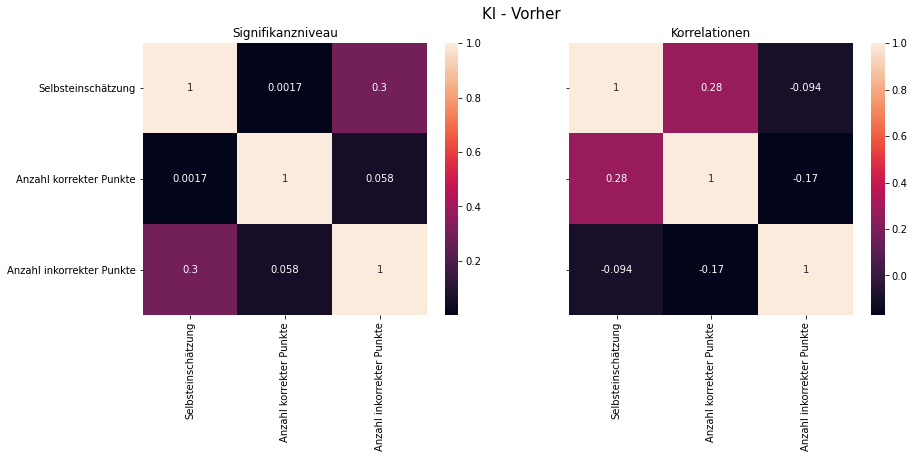

------------------ Nachher ---------------


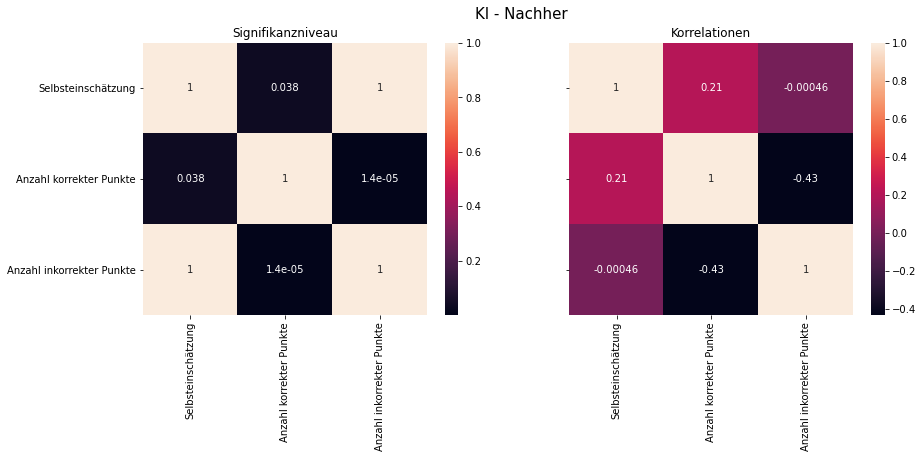

In [276]:
tasks = [("AI-1-v2-1-1", "AI-1-v2-1-2"), ('AI-4-v2-1-4', "AI-4-v2-1-3")]
timepointLabels = ["Vorher", "Nachher"]
timepoint = 0
for tpl in tasks:
    print("------------------", timepointLabels[timepoint], "---------------")
    p_values = pupil_performance_df_rated[[tpl[0], tpl[1]+ "_correct_points", tpl[1]+ "_incorrect_points"]].corr(method=spearmanr_pval)
    
    fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True) #sharey=True
    #fig.suptitle('test title', fontsize=20)
    fig.suptitle("KI - " + timepointLabels[timepoint], fontsize=15)
    
    labels = ["Selbsteinschätzung", "Anzahl korrekter Punkte", "Anzahl inkorrekter Punkte"]
    sns.heatmap(p_values, ax= axes[0], annot= True, xticklabels = labels, yticklabels = labels)
    axes[0].set_title("Signifikanzniveau")    

    sns.heatmap(pupil_performance_df_rated[[tpl[0], tpl[1]+ "_correct_points", tpl[1]+ "_incorrect_points"]].corr(method='spearman'), ax= axes[1], annot= True, xticklabels = labels, yticklabels = labels)
    axes[1].set_title("Korrelationen")
    plt.savefig("plots/KI_" + timepointLabels[timepoint] + "_complete.png", bbox_inches='tight')
    plt.show()
    timepoint +=1

### KI - Textantworten

#### KI - Textantworten - Länge der Abgaben

----------- AI-1-v2-1-2 --------------


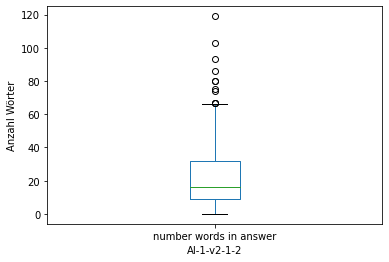

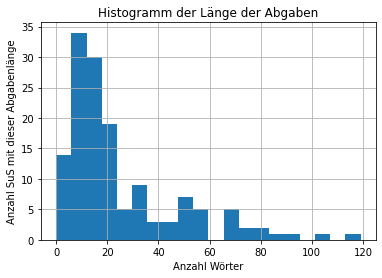

AI-1-v2-1-2
Die meisten Antworten sind zwischen 9.0 und 32.0 Wörtern lang
mean:  24.51
std:  23 2
median:  16.0



----------- AI-4-v2-1-3 --------------


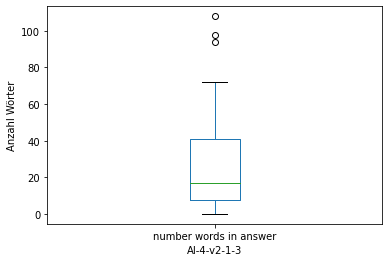

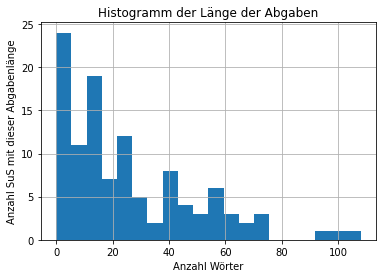

AI-4-v2-1-3
Die meisten Antworten sind zwischen 7.75 und 41.0 Wörtern lang
mean:  25.74
std:  23 2
median:  17.0





In [170]:
for taskId in ["AI-1-v2-1-2", "AI-4-v2-1-3"]:
    print("-----------",taskId,"--------------")
    freetext[freetext["taskId"] == taskId]["number words in answer"].plot(kind="box")
    plt.xlabel(taskId)
    plt.ylabel("Anzahl Wörter")
    plt.show()
    
    freetext[freetext["taskId"] == taskId]["number words in answer"].hist(bins=20)
    plt.title("Histogramm der Länge der Abgaben")
    plt.xlabel("Anzahl Wörter")
    plt.ylabel("Anzahl SuS mit dieser Abgabenlänge")
    plt.show()
        
    q3, q1 = np.percentile(freetext[freetext["taskId"] == taskId]["number words in answer"], [75 ,25])
    mean = np.mean(freetext[freetext["taskId"] == taskId]["number words in answer"])
    std = np.std(freetext[freetext["taskId"] == taskId]["number words in answer"])
    median = np.median(freetext[freetext["taskId"] == taskId]["number words in answer"])
    print(taskId)
    print("Die meisten Antworten sind zwischen " + str(q1) + " und " + str(q3) + " Wörtern lang")
    print("mean: ", round(mean, 2))
    print("std: ", round(std),2)
    print("median: ", median)
    print("\n\n")

#### KI - Textantworten  - unknown

Unknown ist True, wenn:
* die SuS explizit sagen, dass sie es nicht wissen


In [9]:
print("-----Anzahl Abgaben-----")
print("T0: ", len(pupil_performance_df_rated['AI-1-v2-1-2_null_answer'].dropna()))
print("T1: ", len(pupil_performance_df_rated['AI-4-v2-1-3_null_answer'].dropna()))
print("-----'Anzahl Ich weiß es nicht-Abgaben'-----")
print("T0: ", len(pupil_performance_df_rated[pupil_performance_df_rated['AI-1-v2-1-2_unknown']==True]))
print("T1: ", len(pupil_performance_df_rated[pupil_performance_df_rated['AI-4-v2-1-3_unknown']==True]))
print("-----Anzahl Leerabgaben und Plagiate-----")
print("T0: ", len(pupil_performance_df_rated[pupil_performance_df_rated['AI-1-v2-1-2_null_answer']==True]))
print("T1: ", len(pupil_performance_df_rated[pupil_performance_df_rated['AI-4-v2-1-3_null_answer']==True]))

proportionT0unknown = pupil_performance_df_rated[["AI-1-v2-1-2_unknown"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["AI-1-v2-1-2_unknown"]].value_counts()[False].values[0] + pupil_performance_df_rated[["AI-1-v2-1-2_unknown"]].value_counts()[True].values[0])
proportionT1unknown = pupil_performance_df_rated[["AI-4-v2-1-3_unknown"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["AI-4-v2-1-3_unknown"]].value_counts()[False].values[0] + pupil_performance_df_rated[["AI-4-v2-1-3_unknown"]].value_counts()[True].values[0])
proportionT0null = pupil_performance_df_rated[["AI-1-v2-1-2_null_answer"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["AI-1-v2-1-2_null_answer"]].value_counts()[False].values[0] + pupil_performance_df_rated[["AI-1-v2-1-2_null_answer"]].value_counts()[True].values[0])
proportionT1null = pupil_performance_df_rated[["AI-4-v2-1-3_null_answer"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["AI-4-v2-1-3_null_answer"]].value_counts()[False].values[0] + pupil_performance_df_rated[["AI-4-v2-1-3_null_answer"]].value_counts()[True].values[0])

print("\n-----Veränderung der Anteile-----")
print("Proportion Unknown: ", round(proportionT0unknown*100, 2), "-->", round(proportionT1unknown*100,2))

-----Anzahl Abgaben-----
T0:  141
T1:  111
-----'Anzahl Ich weiß es nicht-Abgaben'-----
T0:  2
T1:  3
-----Anzahl Leerabgaben und Plagiate-----
T0:  14
T1:  13

-----Veränderung der Anteile-----
Proportion Unknown:  1.42 --> 2.7


#### KI - Textantworten - Deskriptiv
##### Korrekte und Inkorrekte Punkte vorher und nachher

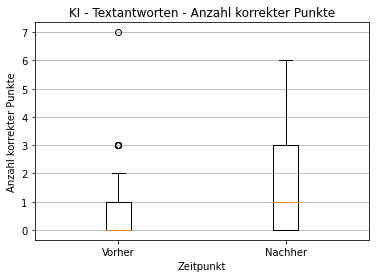

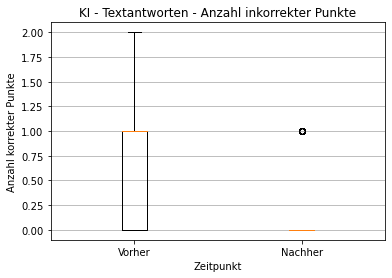

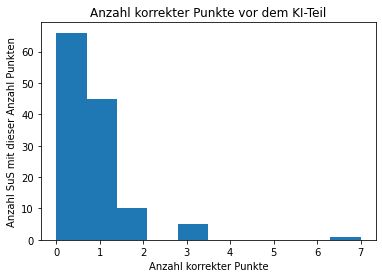

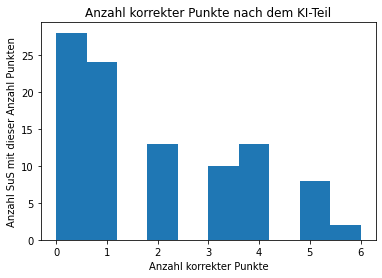

-----correct points-----
AI-1-v2-1-2_correct_points
Q1: 0.0 and Q3: 1.0
median: 0.0
mean: 0.6850393700787402
std: 0.97
min: 0.0 und max: 7.0

AI-4-v2-1-3_correct_points
Q1: 0.0 and Q3: 3.0
median: 1.0
mean: 1.8775510204081634
std: 1.76
min: 0.0 und max: 6.0


-----incorrect points-----
AI-1-v2-1-2_incorrect_points
Q1: 0.0 and Q3: 1.0
median: 1.0
mean: 0.616
std: 0.56
min: 0.0 und max: 2.0

AI-4-v2-1-3_incorrect_points
Q1: 0.0 and Q3: 0.0
median: 0.0
mean: 0.22105263157894736
std: 0.42
min: 0.0 und max: 1.0



In [186]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
labels = ["Vorher", "Nachher"]
bplot1 = ax1.boxplot([pupil_performance_df_rated["AI-1-v2-1-2_correct_points"].dropna(), pupil_performance_df_rated["AI-4-v2-1-3_correct_points"].dropna()],
                     vert=True,
                     labels=labels)
ax1.yaxis.grid(True)
ax1.set_title('KI - Textantworten - Anzahl korrekter Punkte')
ax1.set_xlabel("Zeitpunkt")
ax1.set_ylabel("Anzahl korrekter Punkte")
plt.savefig('plots/KI_freetext_correkt_points.png', bbox_inches='tight')
plt.show()


fig, ax1 = plt.subplots(nrows=1, ncols=1)
labels = ["Vorher", "Nachher"]
bplot1 = ax1.boxplot([pupil_performance_df_rated["AI-1-v2-1-2_incorrect_points"].dropna(), pupil_performance_df_rated["AI-4-v2-1-3_incorrect_points"].dropna()],
                     vert=True,
                     labels=labels)
ax1.yaxis.grid(True)
ax1.set_title('KI - Textantworten - Anzahl inkorrekter Punkte')
ax1.set_xlabel("Zeitpunkt")
ax1.set_ylabel("Anzahl korrekter Punkte")
plt.savefig('plots/KI_freetext_incorrekt_points.png', bbox_inches='tight')
plt.show()


plt.hist(pupil_performance_df_rated["AI-1-v2-1-2_correct_points"].dropna())
plt.title("Anzahl korrekter Punkte vor dem KI-Teil")
plt.ylabel("Anzahl SuS mit dieser Anzahl Punkten")
plt.xlabel("Anzahl korrekter Punkte")
plt.show()

plt.hist(pupil_performance_df_rated["AI-4-v2-1-3_correct_points"].dropna())
plt.title("Anzahl korrekter Punkte nach dem KI-Teil")
plt.ylabel("Anzahl SuS mit dieser Anzahl Punkten")
plt.xlabel("Anzahl korrekter Punkte")
plt.show()

print("-----correct points-----")
surveySliderStatistics(pupil_performance_df_rated["AI-1-v2-1-2_correct_points"])
surveySliderStatistics(pupil_performance_df_rated["AI-4-v2-1-3_correct_points"])

print("\n-----incorrect points-----")
surveySliderStatistics(pupil_performance_df_rated["AI-1-v2-1-2_incorrect_points"])
surveySliderStatistics(pupil_performance_df_rated["AI-4-v2-1-3_incorrect_points"])

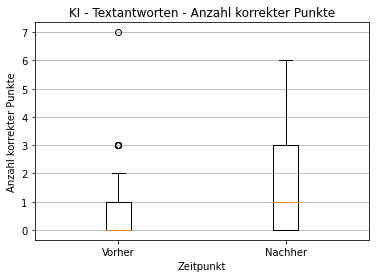

#### KI - Textantworten - Lerneffekt

In [27]:
KIdifferences_correct = calculateDifferences(pupil_performance_df_rated[["AI-4-v2-1-3_correct_points", "AI-1-v2-1-2_correct_points"]])
KIdifferences_incorrect = calculateDifferences(pupil_performance_df_rated[["AI-4-v2-1-3_incorrect_points", "AI-1-v2-1-2_incorrect_points"]])

print("-----Shapiro-----")
print(stats.shapiro(KIdifferences_correct))
print(stats.shapiro(KIdifferences_incorrect))

print("\n-----Signifikanz-----")
print(stats.wilcoxon(KIdifferences_correct))
print(stats.wilcoxon(KIdifferences_incorrect))

print("\n-----Effektstärke-----")
print(cohen_d(pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_correct_points", "AI-1-v2-1-2_correct_points"])["AI-1-v2-1-2_correct_points"], pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_correct_points", "AI-1-v2-1-2_correct_points"])["AI-4-v2-1-3_correct_points"]))
print(cohen_d(pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_incorrect_points", "AI-1-v2-1-2_incorrect_points"])["AI-1-v2-1-2_incorrect_points"], pupil_performance_df_rated.dropna(subset=["AI-4-v2-1-3_incorrect_points", "AI-1-v2-1-2_incorrect_points"])["AI-4-v2-1-3_incorrect_points"]))


-----Shapiro-----
ShapiroResult(statistic=0.8644287586212158, pvalue=8.662321704377973e-08)
ShapiroResult(statistic=0.8164995312690735, pvalue=2.8508673199922896e-09)

-----Signifikanz-----
WilcoxonResult(statistic=122.5, pvalue=5.919715417692041e-10)
WilcoxonResult(statistic=123.0, pvalue=1.5945871800686743e-06)

-----Effektstärke-----
-0.8803577784139401
0.773017651715653


##### Lernfortschritt nach Klasse

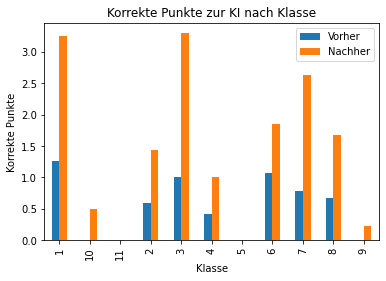

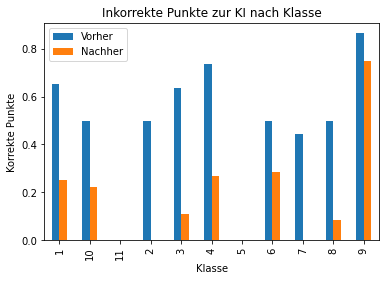

In [194]:
labels = ["Vorher", "Nachher"]
pupil_performance_df_rated.groupby("classId")[["AI-1-v2-1-2_correct_points", "AI-4-v2-1-3_correct_points"]].agg(np.mean).plot(y=["AI-1-v2-1-2_correct_points", "AI-4-v2-1-3_correct_points"], kind="bar")
plt.title("Korrekte Punkte zur KI nach Klasse")
plt.xlabel('Klasse')
plt.ylabel('Korrekte Punkte')
plt.legend(labels)
plt.savefig('plots/KI_textanwort_korrekte_byclass.png', bbox_inches='tight')
plt.show()

pupil_performance_df_rated.groupby("classId")[["AI-1-v2-1-2_incorrect_points", "AI-4-v2-1-3_incorrect_points"]].agg(np.mean).plot(y=["AI-1-v2-1-2_incorrect_points", "AI-4-v2-1-3_incorrect_points"], kind="bar")
plt.title("Inkorrekte Punkte zur KI nach Klasse")
plt.xlabel('Klasse')
plt.ylabel('Korrekte Punkte')
plt.legend(labels)
plt.savefig('plots/KI_textanwort_inkorrekte_byclass.png', bbox_inches='tight')
plt.show()


## 4.2 ML
### ML - Selbsteinschätzung
* T0: 'ML-2-1-1' 'Wie gut weißt du schon, was Maschinelles Lernen ist?'
* T1: 'EvalML-1-5' Wie gut hast du verstanden, was maschinelles Lernen ist?

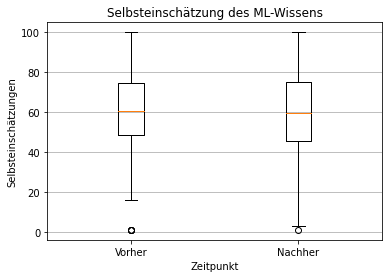

In [54]:
fig, ax1 = plt.subplots(nrows=1, ncols=1) #figsize=(9, 4)
labels = ["Vorher", "Nachher"]
bplot1 = ax1.boxplot([pupil_performance_df["ML-2-1-1"].dropna(), pupil_performance_df["EvalML-1-5"].dropna()],
                     vert=True,
                     #patch_artist=True,
                     labels=labels)
ax1.yaxis.grid(True)
ax1.set_title('Selbsteinschätzung des ML-Wissens')
ax1.set_xlabel("Zeitpunkt")
ax1.set_ylabel("Selbsteinschätzungen")
plt.savefig('plots/ML_selbsteinschätzung.png', bbox_inches='tight')
plt.show()


In [32]:
differences_0_1 = calculateDifferences(pupil_performance_df[["EvalML-1-5", "ML-2-1-1"]])

print("ShapirotestResult", stats.shapiro(differences_0_1), "\n")

print(stats.wilcoxon(differences_0_1))


ShapirotestResult ShapiroResult(statistic=0.9749335646629333, pvalue=0.29257649183273315) 

WilcoxonResult(statistic=700.5, pvalue=0.89434543821884)


#### ML - Selbsteinschätzung - Korrelation mit meiner Bewertung der Textantworten

------------------ Vorher ---------------


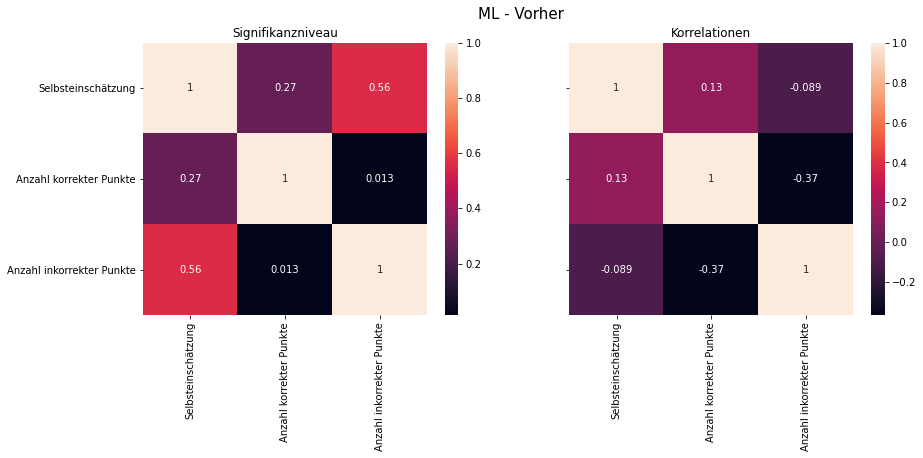

------------------ Nachher ---------------


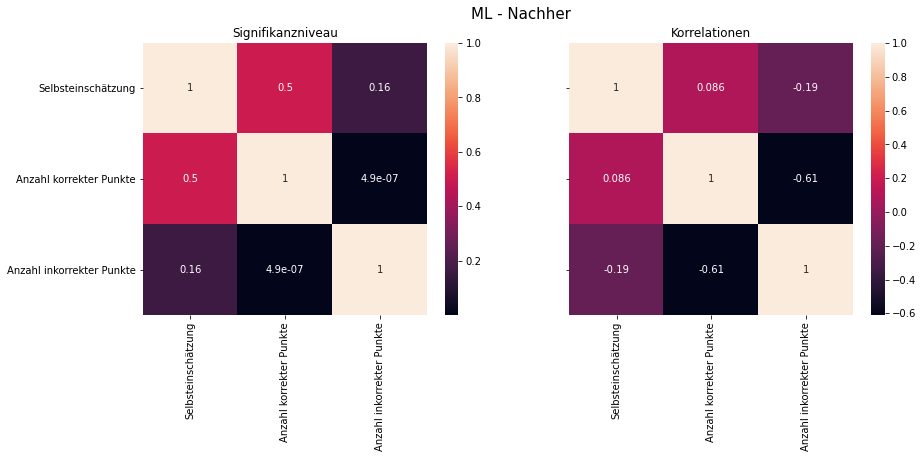

In [277]:
tasks = [("ML-2-1-1", "ML-2-1-2"), ('EvalML-1-5', "EvalML-1-7")]
timepointLabels = ["Vorher", "Nachher"]
timepoint = 0
for tpl in tasks:
    print("------------------", timepointLabels[timepoint], "---------------")
    p_values = pupil_performance_df_rated[[tpl[0], tpl[1]+ "_correct_points", tpl[1]+ "_incorrect_points"]].corr(method=spearmanr_pval)
    
    fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True) #sharey=True
    #fig.suptitle('test title', fontsize=20)
    fig.suptitle("ML - " + timepointLabels[timepoint], fontsize=15)
    
    labels = ["Selbsteinschätzung", "Anzahl korrekter Punkte", "Anzahl inkorrekter Punkte"]
    sns.heatmap(p_values, ax= axes[0], annot= True, xticklabels = labels, yticklabels = labels)
    axes[0].set_title("Signifikanzniveau")    

    sns.heatmap(pupil_performance_df_rated[[tpl[0], tpl[1]+ "_correct_points", tpl[1]+ "_incorrect_points"]].corr(method='spearman'), ax= axes[1], annot= True, xticklabels = labels, yticklabels = labels)
    axes[1].set_title("Korrelationen")
    plt.savefig("plots/ML_" + timepointLabels[timepoint] + "_complete.png", bbox_inches='tight')
    plt.show()
    timepoint +=1

### ML - Textantworten
* 'ML-2-1-1' - Weißt du vielleicht schon etwas über das maschinelle Lernen?
* 'EvalML-1-7' - Was ist ML in eigenen Worten

#### ML - Textantworten - Länge der Abgaben

----------- ML-2-1-2 --------------


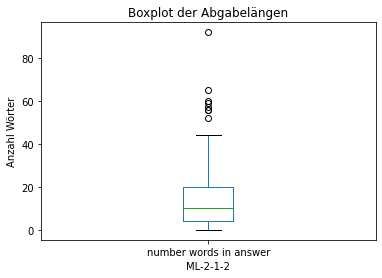

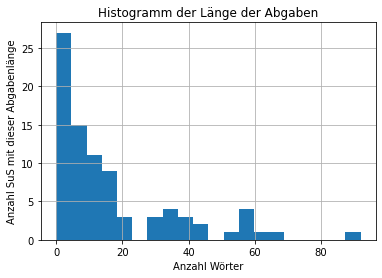

ML-2-1-2
Die meisten Antworten sind zwischen 4.0 und 20.0 Wörtern lang
mean:  16.56
std:  19 2
median:  10.0



----------- EvalML-1-7 --------------


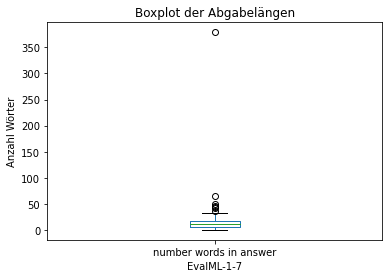

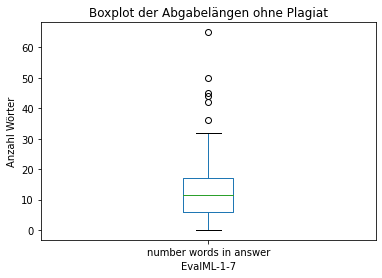

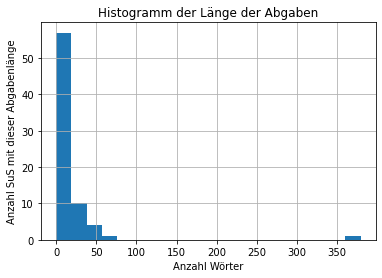

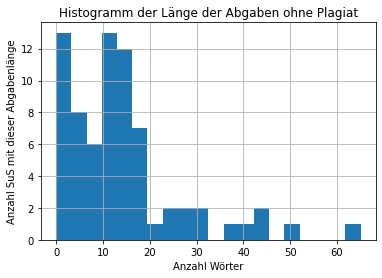

EvalML-1-7
Die meisten Antworten sind zwischen 6.0 und 17.0 Wörtern lang
mean:  18.97
std:  44 2
median:  12.0





In [175]:
for taskId in ["ML-2-1-2", "EvalML-1-7"]:
    print("-----------",taskId,"--------------")
    freetext[freetext["taskId"] == taskId]["number words in answer"].plot(kind="box")
    plt.title("Boxplot der Abgabelängen")
    plt.xlabel(taskId)
    plt.ylabel("Anzahl Wörter")
    plt.show()
    
    if (taskId == "EvalML-1-7"):
        freetext[(freetext["taskId"] == taskId) & (freetext["number words in answer"] < 300 )]["number words in answer"].plot(kind="box")
        plt.title("Boxplot der Abgabelängen ohne Plagiat")
        plt.xlabel(taskId)
        plt.ylabel("Anzahl Wörter")
        plt.show()
    
    freetext[freetext["taskId"] == taskId]["number words in answer"].hist(bins=20)
    plt.title("Histogramm der Länge der Abgaben")
    plt.xlabel("Anzahl Wörter")
    plt.ylabel("Anzahl SuS mit dieser Abgabenlänge")
    plt.show()
    
    if (taskId == "EvalML-1-7"):
        freetext[(freetext["taskId"] == taskId) & (freetext["number words in answer"] < 300 )]["number words in answer"].hist(bins=20)
        plt.title("Histogramm der Länge der Abgaben ohne Plagiat")
        plt.xlabel("Anzahl Wörter")
        plt.ylabel("Anzahl SuS mit dieser Abgabenlänge")
        plt.show()
        
    q3, q1 = np.percentile(freetext[freetext["taskId"] == taskId]["number words in answer"], [75 ,25])
    mean = np.mean(freetext[freetext["taskId"] == taskId]["number words in answer"])
    std = np.std(freetext[freetext["taskId"] == taskId]["number words in answer"])
    median = np.median(freetext[freetext["taskId"] == taskId]["number words in answer"])
    print(taskId)
    print("Die meisten Antworten sind zwischen " + str(q1) + " und " + str(q3) + " Wörtern lang")
    print("mean: ", round(mean, 2))
    print("std: ", round(std),2)
    print("median: ", median)
    print("\n\n")

#### ML - Textantworten - unknown

In [8]:
print("-----Anzahl Abgaben-----")
print("T0: ", len(pupil_performance_df_rated['ML-2-1-2_null_answer'].dropna()))
print("T1: ", len(pupil_performance_df_rated['EvalML-1-7_null_answer'].dropna()))
print("-----'Anzahl Ich weiß es nicht-Abgaben'-----")
print("T0: ", len(pupil_performance_df_rated[pupil_performance_df_rated['ML-2-1-2_unknown']==True]))
print("T1: ", len(pupil_performance_df_rated[pupil_performance_df_rated['EvalML-1-7_unknown']==True]))
print("-----Anzahl Leerabgaben und Plagiate-----")
print("T0: ", len(pupil_performance_df_rated[pupil_performance_df_rated['ML-2-1-2_null_answer']==True]))
print("T1: ", len(pupil_performance_df_rated[pupil_performance_df_rated['EvalML-1-7_null_answer']==True]))

proportionT0unknown = round((pupil_performance_df_rated[["ML-2-1-2_unknown"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["ML-2-1-2_unknown"]].value_counts()[False].values[0] + pupil_performance_df_rated[["ML-2-1-2_unknown"]].value_counts()[True].values[0]))*100,2)
proportionT1unknown = round((pupil_performance_df_rated[["EvalML-1-7_unknown"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["EvalML-1-7_unknown"]].value_counts()[False].values[0] + pupil_performance_df_rated[["EvalML-1-7_unknown"]].value_counts()[True].values[0]))*100,2)
proportionT0null = round((pupil_performance_df_rated[["ML-2-1-2_null_answer"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["ML-2-1-2_null_answer"]].value_counts()[False].values[0] + pupil_performance_df_rated[["ML-2-1-2_null_answer"]].value_counts()[True].values[0]))*100,2)
proportionT1null = round((pupil_performance_df_rated[["EvalML-1-7_null_answer"]].value_counts()[True].values[0] / (pupil_performance_df_rated[["EvalML-1-7_null_answer"]].value_counts()[False].values[0] + pupil_performance_df_rated[["EvalML-1-7_null_answer"]].value_counts()[True].values[0]))*100,2)

print("\n-----Prozentuale Veränderung-----")
print("Proportion Unknown: ", proportionT0unknown, "-->", proportionT1unknown)

-----Anzahl Abgaben-----
T0:  84
T1:  72
-----'Anzahl Ich weiß es nicht-Abgaben'-----
T0:  29
T1:  7
-----Anzahl Leerabgaben und Plagiate-----
T0:  11
T1:  9

-----Prozentuale Veränderung-----
Proportion Unknown:  34.52 --> 9.72


#### ML - Textantworten - Deskriptiv

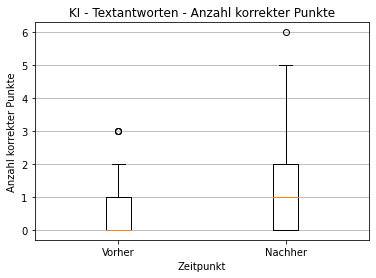

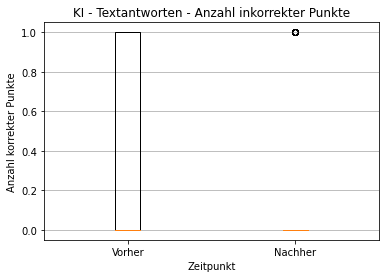

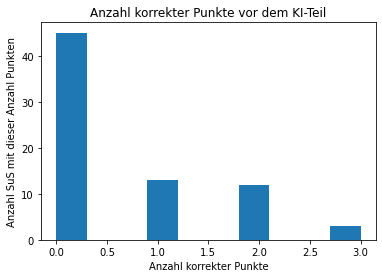

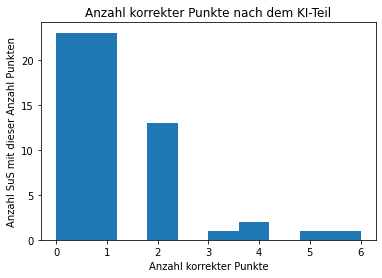

-----correct points-----
ML-2-1-2_correct_points
Q1: 0.0 and Q3: 1.0
median: 0.0
mean: 0.6301369863013698
std: 0.91
min: 0.0 und max: 3.0

EvalML-1-7_correct_points
Q1: 0.0 and Q3: 2.0
median: 1.0
mean: 1.109375
std: 1.25
min: 0.0 und max: 6.0


-----incorrect points-----
ML-2-1-2_incorrect_points
Q1: 0.0 and Q3: 1.0
median: 0.0
mean: 0.4666666666666667
std: 0.5
min: 0.0 und max: 1.0

EvalML-1-7_incorrect_points
Q1: 0.0 and Q3: 0.0
median: 0.0
mean: 0.22807017543859648
std: 0.42
min: 0.0 und max: 1.0



In [185]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
labels = ["Vorher", "Nachher"]
bplot1 = ax1.boxplot([pupil_performance_df_rated["ML-2-1-2_correct_points"].dropna(), pupil_performance_df_rated["EvalML-1-7_correct_points"].dropna()],
                     vert=True,
                     labels=labels)
ax1.yaxis.grid(True)
ax1.set_title('KI - Textantworten - Anzahl korrekter Punkte')
ax1.set_xlabel("Zeitpunkt")
ax1.set_ylabel("Anzahl korrekter Punkte")
plt.savefig('plots/ML_freetext_correkt_points.png', bbox_inches='tight')
plt.show()


fig, ax1 = plt.subplots(nrows=1, ncols=1)
labels = ["Vorher", "Nachher"]
bplot1 = ax1.boxplot([pupil_performance_df_rated["ML-2-1-2_incorrect_points"].dropna(), pupil_performance_df_rated["EvalML-1-7_incorrect_points"].dropna()],
                     vert=True,
                     labels=labels)
ax1.yaxis.grid(True)
ax1.set_title('KI - Textantworten - Anzahl inkorrekter Punkte')
ax1.set_xlabel("Zeitpunkt")
ax1.set_ylabel("Anzahl korrekter Punkte")
plt.savefig('plots/ML_freetext_incorrekt_points.png', bbox_inches='tight')
plt.show()


plt.hist(pupil_performance_df_rated["ML-2-1-2_correct_points"].dropna())
plt.title("Anzahl korrekter Punkte vor dem KI-Teil")
plt.ylabel("Anzahl SuS mit dieser Anzahl Punkten")
plt.xlabel("Anzahl korrekter Punkte")
plt.show()

plt.hist(pupil_performance_df_rated["EvalML-1-7_correct_points"].dropna())
plt.title("Anzahl korrekter Punkte nach dem KI-Teil")
plt.ylabel("Anzahl SuS mit dieser Anzahl Punkten")
plt.xlabel("Anzahl korrekter Punkte")
plt.show()

print("-----correct points-----")
surveySliderStatistics(pupil_performance_df_rated["ML-2-1-2_correct_points"])
surveySliderStatistics(pupil_performance_df_rated["EvalML-1-7_correct_points"])

print("\n-----incorrect points-----")
surveySliderStatistics(pupil_performance_df_rated["ML-2-1-2_incorrect_points"])
surveySliderStatistics(pupil_performance_df_rated["EvalML-1-7_incorrect_points"])

#### ML - Textantworten - Lerneffekt

In [37]:
MLdifferences_correct = calculateDifferences(pupil_performance_df_rated[["EvalML-1-7_correct_points", "ML-2-1-2_correct_points"]])
MLdifferences_incorrect = calculateDifferences(pupil_performance_df_rated[["EvalML-1-7_incorrect_points", "ML-2-1-2_incorrect_points"]])

print("\n-----Normalverteilung?-----")
print(stats.shapiro(MLdifferences_correct))
print(stats.shapiro(MLdifferences_incorrect))

print("\n-----Signifikanz-----")
print(stats.wilcoxon(MLdifferences_correct))
print(stats.wilcoxon(MLdifferences_incorrect))

print("\n-----Effektstärke-----")
print(cohen_d(pupil_performance_df_rated.dropna(subset=["EvalML-1-7_correct_points", "ML-2-1-2_correct_points"])["EvalML-1-7_correct_points"], pupil_performance_df_rated.dropna(subset=["EvalML-1-7_correct_points", "ML-2-1-2_correct_points"])["ML-2-1-2_correct_points"]))
print(cohen_d(pupil_performance_df_rated.dropna(subset=["EvalML-1-7_incorrect_points", "ML-2-1-2_incorrect_points"])["EvalML-1-7_incorrect_points"], pupil_performance_df_rated.dropna(subset=["EvalML-1-7_incorrect_points", "ML-2-1-2_incorrect_points"])["AI-4-v2-1-3_incorrect_points"]))



-----Normalverteilung?-----
ShapiroResult(statistic=0.863905131816864, pvalue=8.516922389389947e-05)
ShapiroResult(statistic=0.6908186674118042, pvalue=1.0665431545930915e-05)

-----Signifikanz-----
WilcoxonResult(statistic=61.5, pvalue=0.016453801586694634)
WilcoxonResult(statistic=7.0, pvalue=0.4142161782425253)

-----Effektstärke-----
0.39490425053246486
0.9095394684417764


/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


##### ML - Textantworten - Unterschiede zwischen Klassen

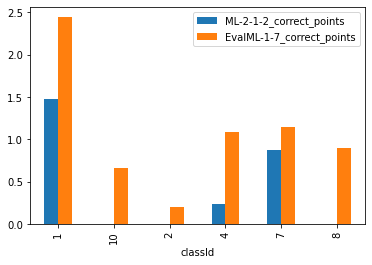

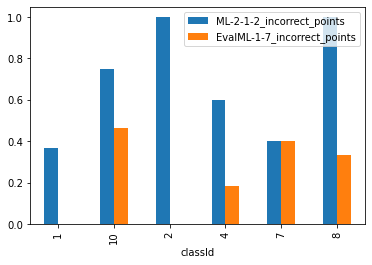

,ML-2-1-2_correct_points,EvalML-1-7_correct_points
classId,,
1,1.473684,2.444444
10,0.000000,0.666667
2,0.000000,0.200000
4,0.230769,1.090909
7,0.875000,1.142857
8,0.000000,0.900000


In [10]:
# manche Klassen haben wert null --> sieht man im barplot nicht gut
pupil_performance_df_rated.groupby("classId")[["ML-2-1-2_correct_points", "EvalML-1-7_correct_points"]].agg(np.mean).dropna().plot(y=["ML-2-1-2_correct_points", "EvalML-1-7_correct_points"], kind="bar")
plt.show()

pupil_performance_df_rated.groupby("classId")[["ML-2-1-2_incorrect_points", "EvalML-1-7_incorrect_points"]].agg(np.mean).dropna().plot(y=["ML-2-1-2_incorrect_points", "EvalML-1-7_incorrect_points"], kind="bar")
plt.show()

pupil_performance_df_rated.groupby("classId")[["ML-2-1-2_correct_points", "EvalML-1-7_correct_points"]].agg(np.mean).dropna()


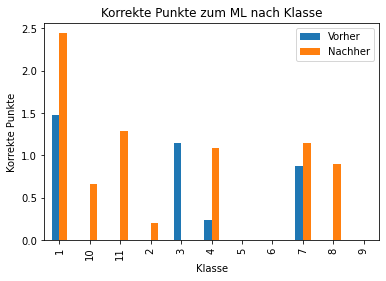

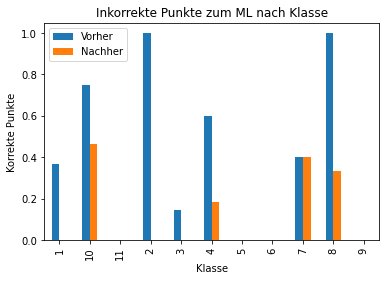

In [197]:
labels = ["Vorher", "Nachher"]
pupil_performance_df_rated.groupby("classId")[["ML-2-1-2_correct_points", "EvalML-1-7_correct_points"]].agg(np.mean).plot(y=["ML-2-1-2_correct_points", "EvalML-1-7_correct_points"], kind="bar")
plt.title("Korrekte Punkte zum ML nach Klasse")
plt.xlabel('Klasse')
plt.ylabel('Korrekte Punkte')
plt.legend(labels)
plt.savefig('plots/ML_textanwort_korrekte_byclass.png', bbox_inches='tight')
plt.show()

pupil_performance_df_rated.groupby("classId")[["ML-2-1-2_incorrect_points", "EvalML-1-7_incorrect_points"]].agg(np.mean).plot(y=["ML-2-1-2_incorrect_points", "EvalML-1-7_incorrect_points"], kind="bar")
plt.title("Inkorrekte Punkte zum ML nach Klasse")
plt.xlabel('Klasse')
plt.ylabel('Korrekte Punkte')
plt.legend(labels)
plt.savefig('plots/ML_textanwort_inkorrekte_byclass.png', bbox_inches='tight')
plt.show()


### Grenzen ML - Textantworten

In [62]:
print(pupil_performance_df_rated.where(pupil_performance_df_rated["LimitsML-1-2_null_answer"] != True)["LimitsML-1-2_correct_points"].dropna().value_counts())

number_correct_cases = pupil_performance_df_rated.where(pupil_performance_df_rated["LimitsML-1-2_null_answer"] != True)["LimitsML-1-2_correct_points"].dropna().value_counts().values[0]
number_incorrect_cases = pupil_performance_df_rated.where(pupil_performance_df_rated["LimitsML-1-2_null_answer"] != True)["LimitsML-1-2_correct_points"].dropna().value_counts().values[1]
percentage_correct = number_correct_cases / (number_correct_cases + number_incorrect_cases)

print("\nAnteil richtiger Antworten: ", round(percentage_correct, 4))

1.0    40
0.0    29
Name: LimitsML-1-2_correct_points, dtype: int64

Anteil richtiger Antworten:  0.5797


#### Grenzen ML - Textantworten - Unterschiede zwischen den Klassen

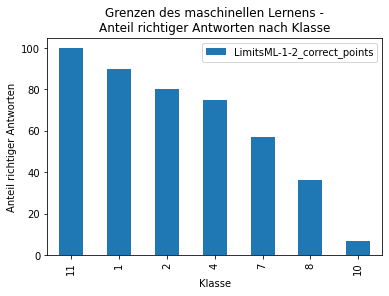

In [136]:
#pupil_performance_df_rated.where(pupil_performance_df_rated["LimitsML-1-2_null_answer"] != True).groupby("classId")["LimitsML-1-2_correct_points"].agg(np.mean).dropna().plot(kind="bar")
pd.DataFrame(pupil_performance_df_rated.where(pupil_performance_df_rated["LimitsML-1-2_null_answer"] != True).groupby("classId")["LimitsML-1-2_correct_points"].agg(np.mean)*100).dropna().sort_values(by="LimitsML-1-2_correct_points",ascending=False).plot(kind="bar", sort_columns=False)
plt.title("Grenzen des maschinellen Lernens -\nAnteil richtiger Antworten nach Klasse")
plt.xlabel('Klasse')
plt.ylabel('Anteil richtiger Antworten')
plt.savefig('plots/GrenzenMLbyKlasse.png', bbox_inches='tight')
plt.show()
